In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from PIL import Image
from resizeimage import resizeimage
import cv2
import os
from IPython.display import clear_output
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from time import time

Definimos Paths de los archivos

In [2]:
path_train = "./chest_xray/train/"
path_test = "./chest_xray/test/"
path_val = "./chest_xray/val/"


Definimos una funcion para subir el contraste de las imagenes

In [10]:
def hist(img):
  img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
  img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
  hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
  return hist_equalization_result

Importamos las imagenes X_train y creamos un vector de labels y_train

In [12]:
path_nor_train = path_train + "NORMAL"
path_neu_train = path_train + "PNEUMONIA"

porcentaje = 1
porcentaje = int(1/porcentaje)

n_imagenes_nor_train = len(listdir(path_nor_train)) // porcentaje
n_imagenes_neu_train = len(listdir(path_neu_train)) // porcentaje
n_imagenes_neu_train = n_imagenes_nor_train #Hago esto para tener el mismo número de datos de 
                                            #una clase que de la otra

imagenes_normal = np.zeros(shape=(n_imagenes_nor_train, 224, 224))
imagenes_pneumonia = np.zeros(shape=(n_imagenes_nor_train, 224, 224)) 

y_train = np.zeros(shape=(n_imagenes_nor_train + n_imagenes_neu_train))

for condicion in ["NORMAL", "PNEUMONIA"]:
    path = path_train + condicion
    lista_directorios = listdir(path)
    
    for index, im in enumerate(lista_directorios[0:len(lista_directorios)// porcentaje]):
        imagen = cv2.imread(path + "/" + im)

        imagen = hist(imagen) #Sube el contraste de las imagenes
        imagen = cv2.resize(imagen, (224,224))[:,:,0]
        
        if condicion == "NORMAL":
            imagenes_normal[index] += imagen
            y_train[index] += 0
        else:
            imagenes_pneumonia[index] += imagen
            y_train[index] += 1
        
        clear_output(wait=True)
        print(str(100*(index+1)/(len(lista_directorios)//porcentaje)) + "%")
                
        if index >= (n_imagenes_neu_train-1):
            break


print(imagenes_normal[0].shape, len(imagenes_pneumonia), type(imagenes_normal[0]))

34.60645161290323%
(224, 224) 1341 <class 'numpy.ndarray'>


Visualizamos una imagen

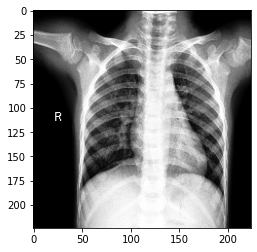

In [13]:
plt.imshow(imagenes_normal[68], cmap="Greys_r")
plt.show()

Convertimos a las imágenes en vectores unidimensionales

In [14]:
imagenes_nor = np.array(imagenes_normal)
imagenes_neu = np.array(imagenes_pneumonia)

img_nor = imagenes_nor.reshape(len(imagenes_nor), -1)
img_neu = imagenes_neu.reshape(len(imagenes_neu), -1)

print(img_nor.shape, img_neu.shape)

(1341, 50176) (1341, 50176)


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Unimos las imágenes en una matriz que se llama X_train

In [16]:
X_train = np.concatenate([img_nor, img_neu])

In [17]:
X_train.shape

(2682, 50176)

Hacemos PCA

In [18]:
pca = PCA(n_components=200)
pca.fit(X_train)

PCA(n_components=200)

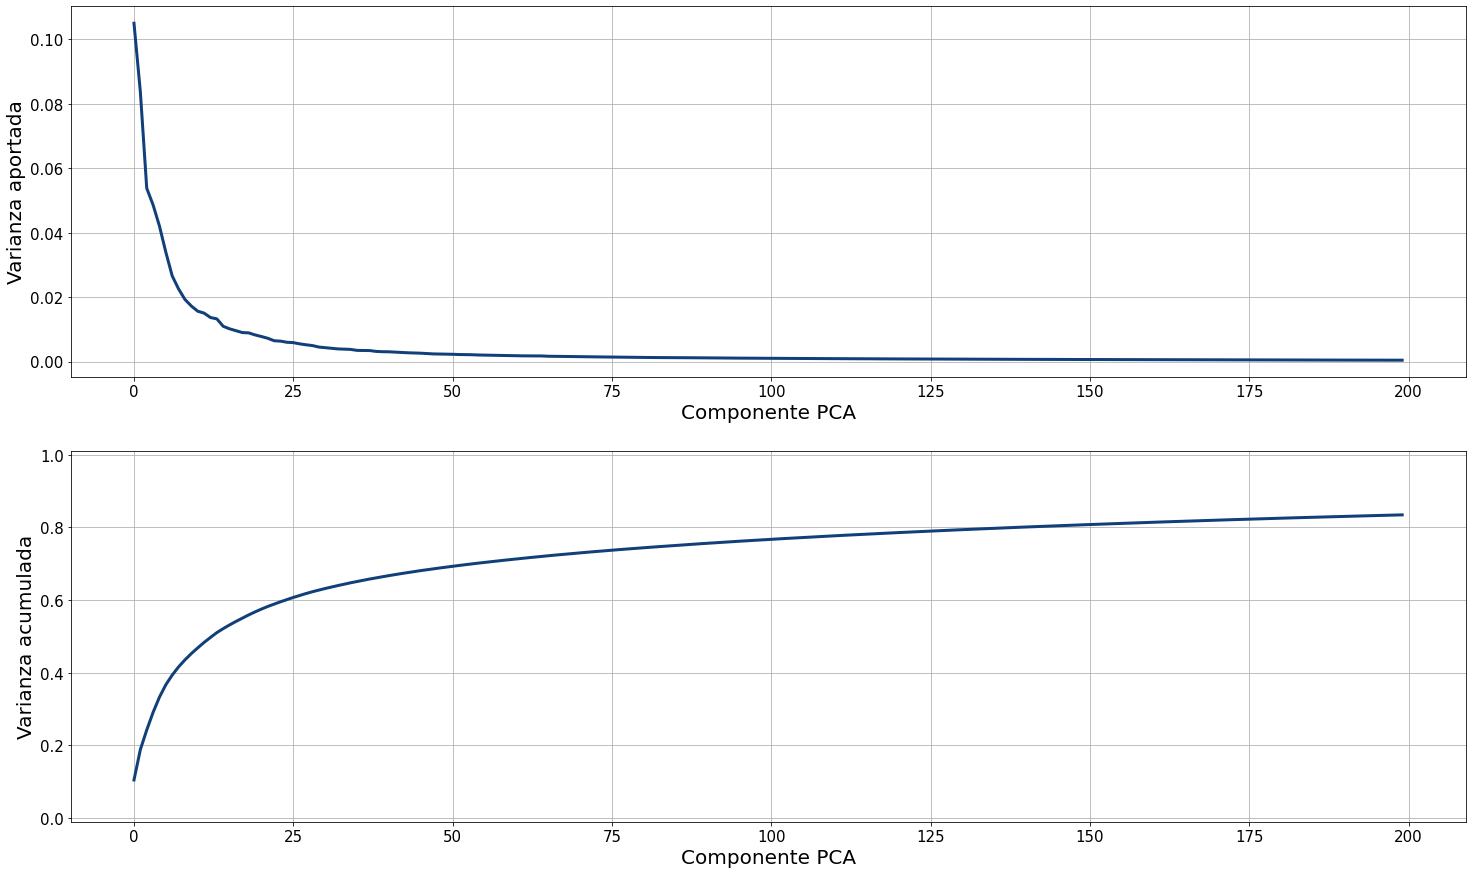

In [11]:
%matplotlib inline


fig, (ax1, ax2) = plt.subplots(2, figsize=(25,15))
ax1.plot(pca.explained_variance_ratio_, linewidth=3, color="#103f79")

ax1.grid()
ax1.tick_params(labelsize=15)
ax1.set_xlabel("Componente PCA", fontsize=20)
ax1.set_ylabel("Varianza aportada", fontsize=20)


acumulada = np.cumsum(pca.explained_variance_ratio_)
ax2.plot(acumulada, linewidth=3, color="#103f79")
ax2.grid()
ax2.tick_params(labelsize=15)
ax2.set_xlabel("Componente PCA", fontsize=20)
ax2.set_ylabel("Varianza acumulada", fontsize=20)
ax2.set_ylim([-0.01,1.01])
plt.show()

Visualizamos las primeras componentes de PCA

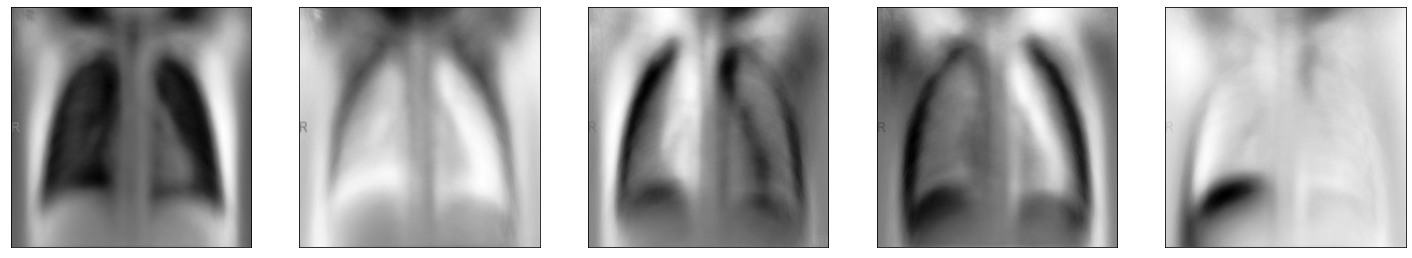

In [12]:
fig, ax = plt.subplots(1, 5, figsize=(25,5))
for index in range(5):
  ax[index].imshow(pca.components_[index].reshape(224,224), cmap="Greys_r")
  ax[index].set_xticks([])
  ax[index].set_yticks([])
plt.show()

Reconstruimos la imagen del principio haciendo la inversa de PCA

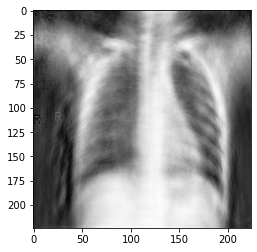

In [13]:
X_pca = pca.transform(X_train)
X_reconstruido = pca.inverse_transform(X_pca[68])

plt.imshow(X_reconstruido.reshape(224,224), cmap="Greys_r")
plt.show()

Visualizamos la primera componente vs la segunda con el label de cada pulmón

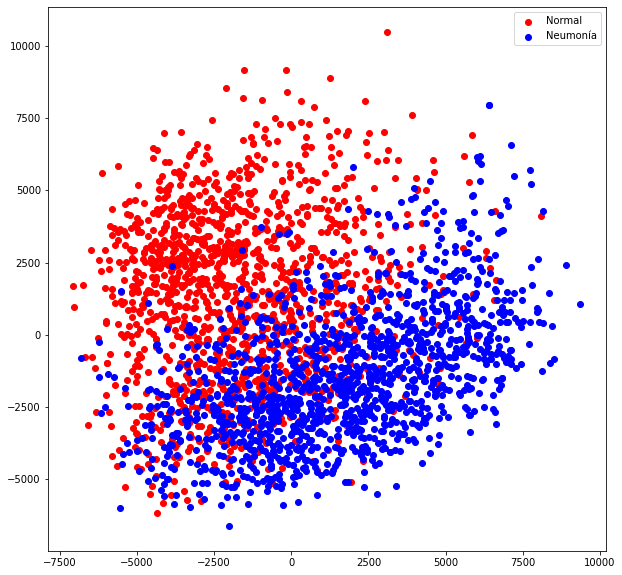

In [14]:

fig, ax = plt.subplots(1, figsize=(10,10))

#ax.scatter(X_pca[:,0], X_pca[:,1], c=y_train)
ax.scatter(X_pca[y_train == 0][:,0], X_pca[y_train == 0][:,1], c="red", label="Normal")
ax.scatter(X_pca[y_train == 1][:,0], X_pca[y_train == 1][:,1], c="b", label="Neumonía")
ax.legend()
plt.show()

Importamos los datos de validación para intentar clasificarlos

In [15]:
n_imagenes = 8

img_nor_val = np.zeros(shape=(n_imagenes, 224, 224))
img_neu_val = np.zeros(shape=(n_imagenes, 224, 224))

y_val = np.zeros(shape=2*n_imagenes)

for condicion in ["NORMAL", "PNEUMONIA"]:
    for index, im in enumerate(listdir(path_val + condicion)):
        imagen = cv2.imread(path_val + condicion + "/" + im)
        
        imagen = hist(imagen)
        imagen = cv2.resize(imagen, (224,224))[:,:,0]
        
        if condicion == "NORMAL":
            img_nor_val[index] += imagen
            y_val[index] += 0
        else:
            img_neu_val[index] += imagen
            y_val[index] += 1
        
        clear_output(wait=True)
        print(str(100*(index+1)/n_imagenes) + "%")
        
        if index >= (n_imagenes-1):
            break


print(img_nor_val[0].shape, len(img_neu_val), type(img_nor_val[0]))

100.0%
(224, 224) 8 <class 'numpy.ndarray'>


Importo los Test también ya q tamo

In [16]:
n_imagenes_test = 100

img_nor_test = np.zeros(shape=(n_imagenes_test, 224, 224))
img_neu_test = np.zeros(shape=(n_imagenes_test, 224, 224))

y_test = np.zeros(shape=2*n_imagenes_test)

for condicion in ["NORMAL", "PNEUMONIA"]:
    for index, im in enumerate(listdir(path_test + condicion)):
        imagen = cv2.imread(path_test + condicion + "/" + im)
        
        imagen = hist(imagen)
        imagen = cv2.resize(imagen, (224,224))[:,:,0]
        
        if condicion == "NORMAL":
            img_nor_test[index] += imagen
            y_test[index] += 0
        else:
            img_neu_test[index] += imagen
            y_test[index] += 1
        
        clear_output(wait=True)
        print(str(100*(index+1)/n_imagenes_test) + "%")
        
        if index >= (n_imagenes_test-1):
            break


print(img_nor_test[0].shape, len(img_neu_test), type(img_nor_test[0]))

100.0%
(224, 224) 100 <class 'numpy.ndarray'>


Convertimos las imagenes en vectores unidimensionales y los appendeamos a la matriz X_val. Lo mismo con X_test

In [17]:
img_nor_val = img_nor_val.reshape(len(img_nor_val), -1)
img_neu_val = img_neu_val.reshape(len(img_neu_val), -1)

X_val = np.concatenate([img_nor_val, img_neu_val])

img_nor_test = img_nor_test.reshape(len(img_nor_test), -1)
img_neu_test = img_neu_test.reshape(len(img_neu_test), -1)

X_test = np.concatenate([img_nor_test, img_neu_test])

Hacemos regresión logística

In [18]:
reglog = LogisticRegression(penalty="l1", solver="liblinear")

#Transformo PCA a X_val
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

reglog.fit(X_pca, y_train)
score_val = reglog.score(X_val_pca, y_val)
score_test = reglog.score(X_test_pca, y_test)

print(score_val)
print(score_test)

0.875
0.625
